In [49]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import psycopg2
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [129]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    return df

In [130]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [131]:
for route in routes:
    add_extra_data(route)

In [132]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [105]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

# Data Exploration

In [133]:
def spread_of_time(df, route):
    hour_min = [x[11:15] + '0' for x in df['expected_arrival']]
    for_aggr = df.assign(hour_min = hour_min)
    for_aggr = for_aggr.groupby('hour_min').count().reset_index()

    arrival_times = [dt.datetime.strptime(time, '%H:%M') for time in for_aggr['hour_min']]

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.scatter(arrival_times, for_aggr['bus_stop_name'])
    ax.set_title("Spread of time of data collected for bus route {}".format(route))
    ax.set_xlim(dt.datetime.strptime('00:00', '%H:%M'), dt.datetime.strptime('23:59', '%H:%M'))
    date_form = DateFormatter("%H-%M")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xlabel("Time of day")
    ax.set_ylabel("Occurences")
    plt.show()

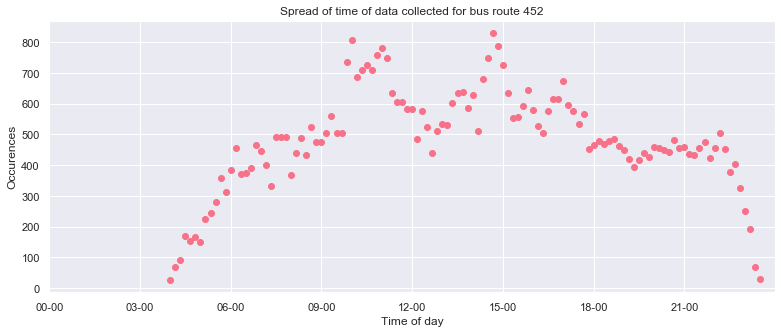

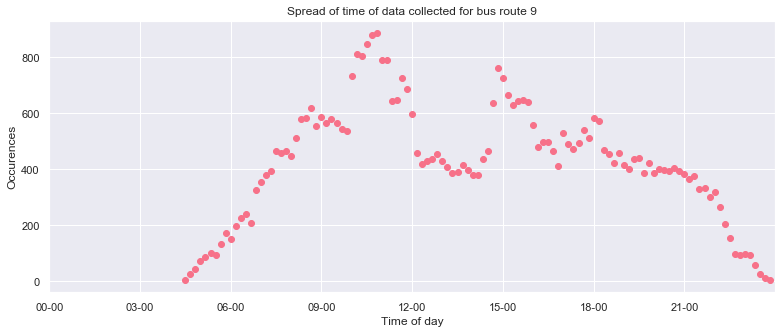

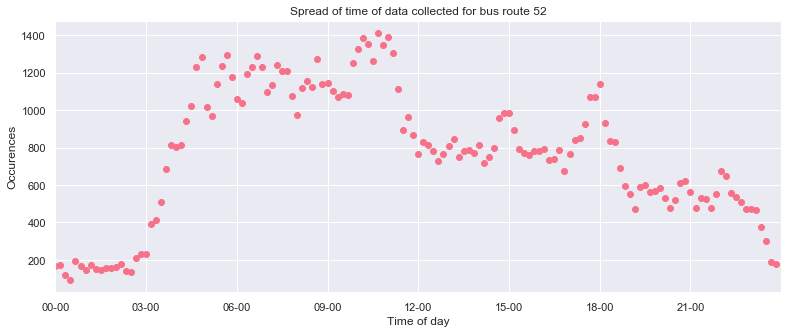

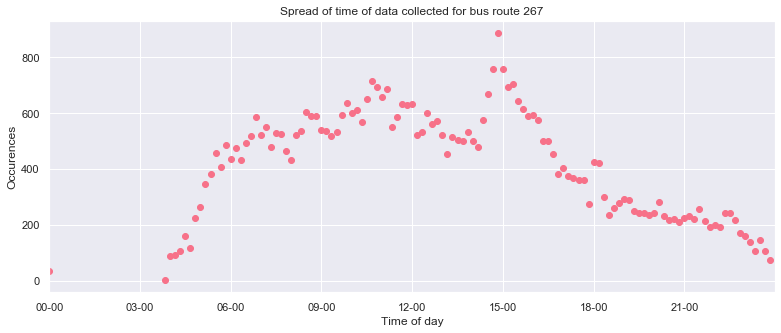

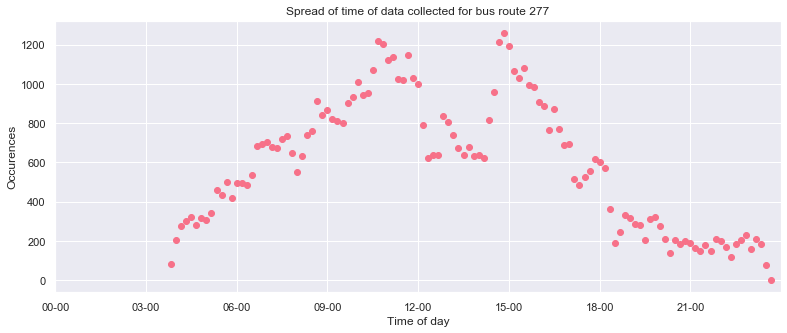

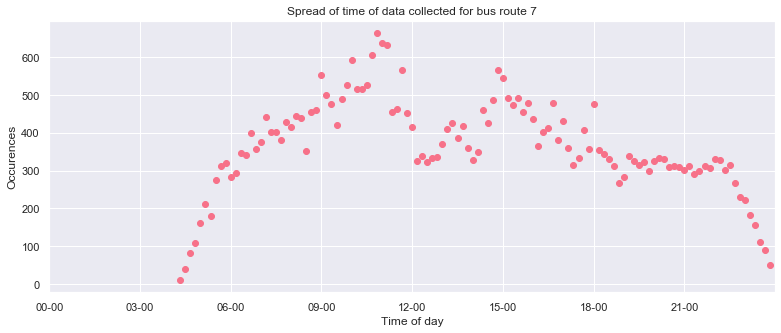

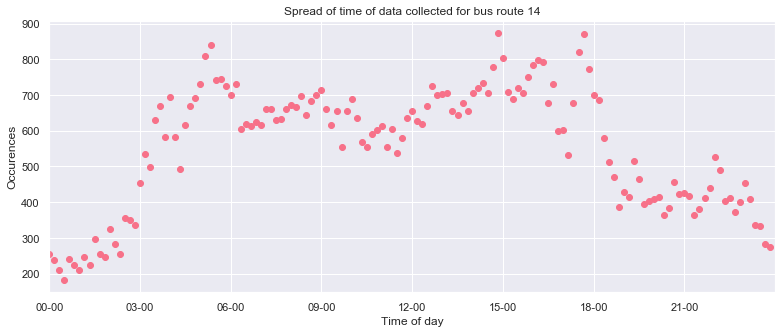

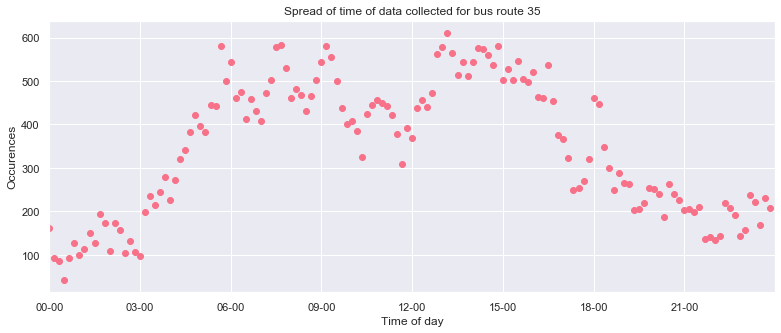

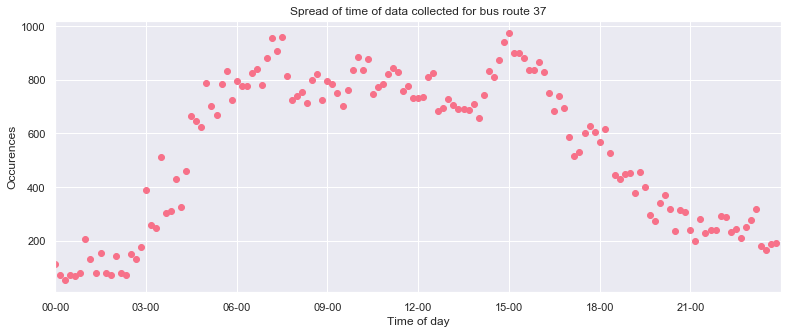

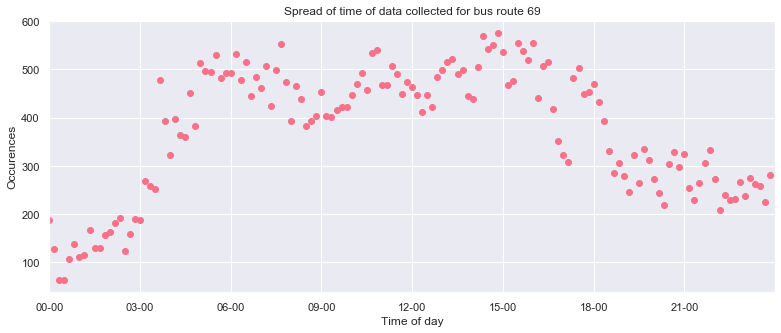

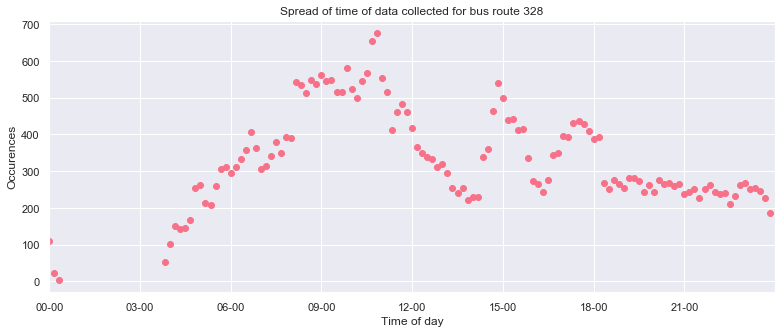

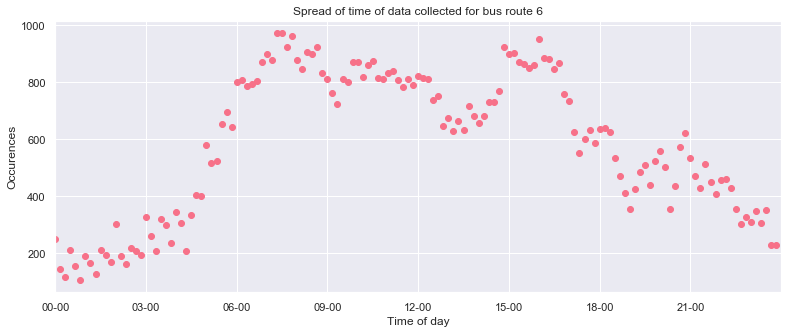

In [102]:
for route in routes:
    spread_of_time(data[route], route)

In [134]:
def spread_of_day_of_week(df, route):

    day_of_week = [x[:10] for x in df['expected_arrival']]
    day_of_week = [dt.datetime.strptime(date, '%Y-%m-%d') for date in day_of_week]

    day_of_week = [calendar.day_name[date.weekday()] for date in day_of_week]
    for_aggr = df.assign(day_of_week = day_of_week)
    for_aggr = for_aggr.groupby('day_of_week').count().reset_index()

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(for_aggr['day_of_week'], for_aggr['bus_stop_name'])
    ax.set_title("Spread of days of the week for data collected for route {}".format(route))
    ax.set_ylim(0)
    ax.set_xlabel("Day of Week")
    ax.set_ylabel("Occurences")
    plt.show()

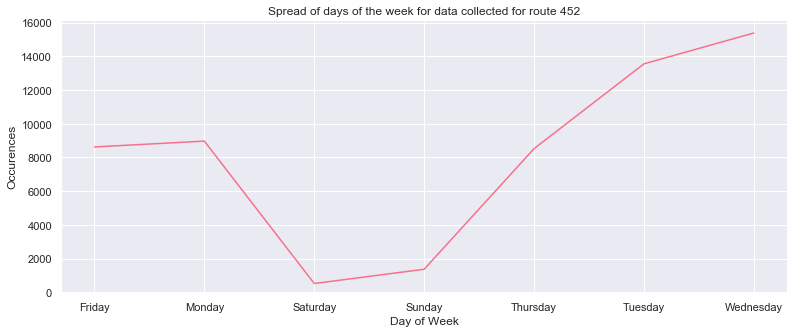

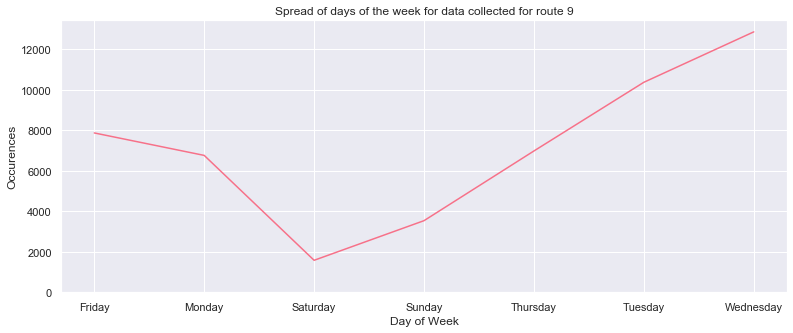

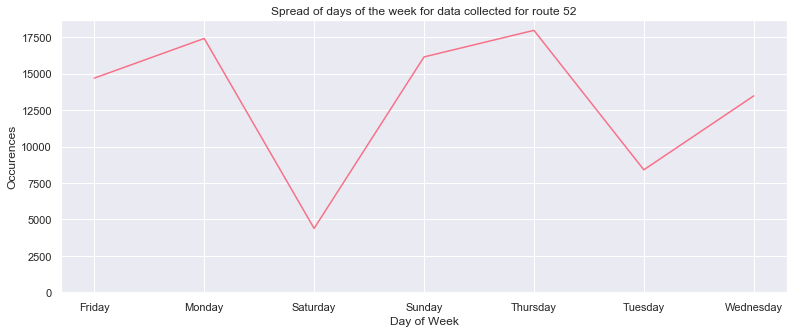

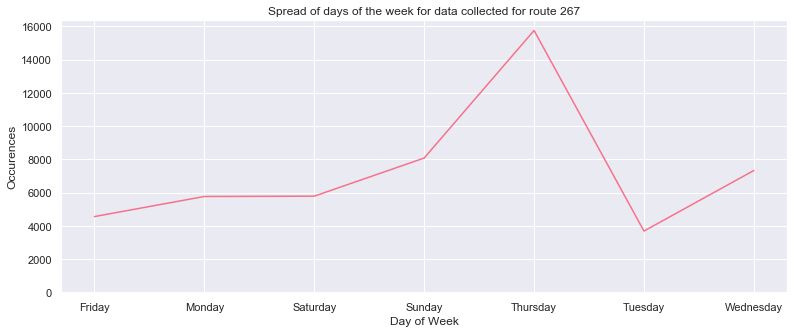

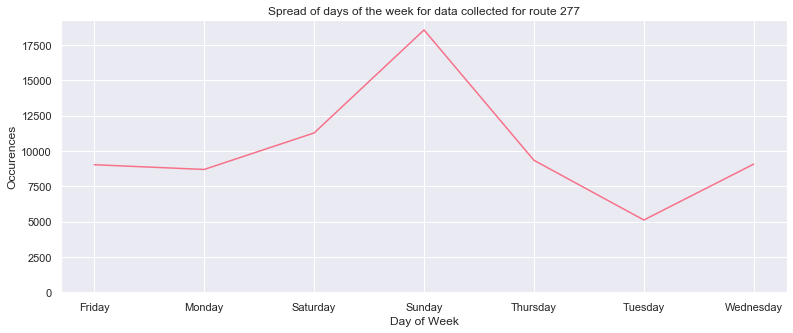

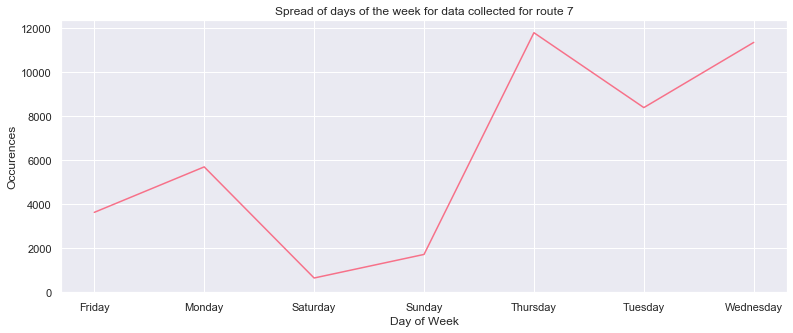

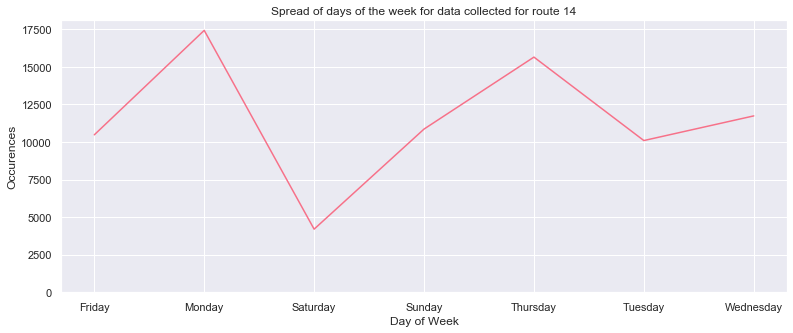

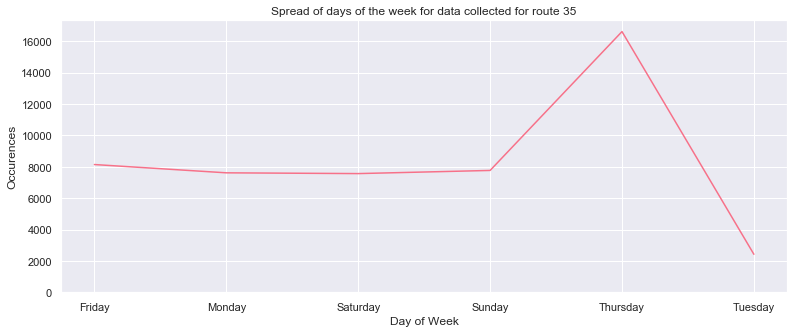

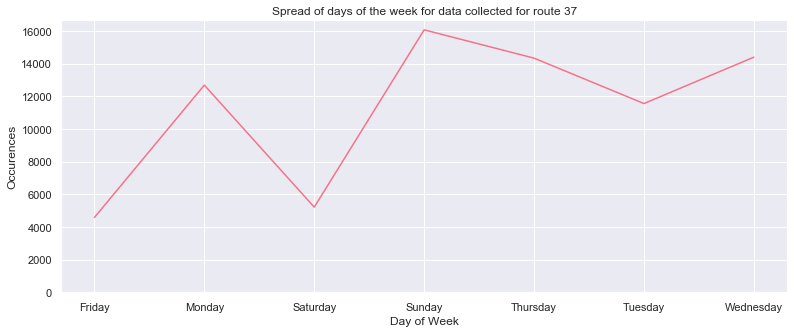

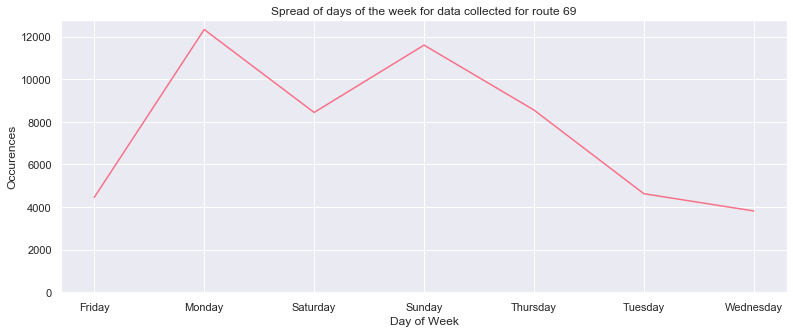

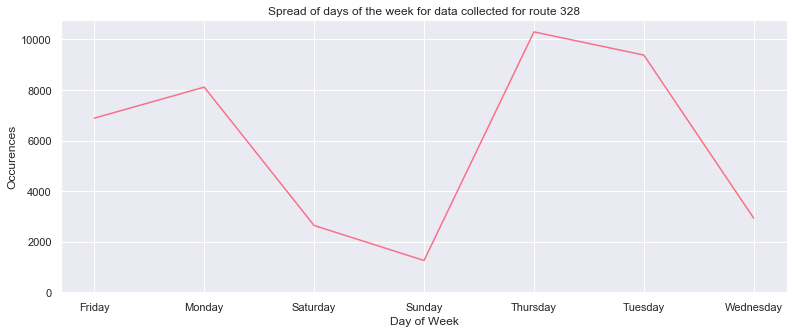

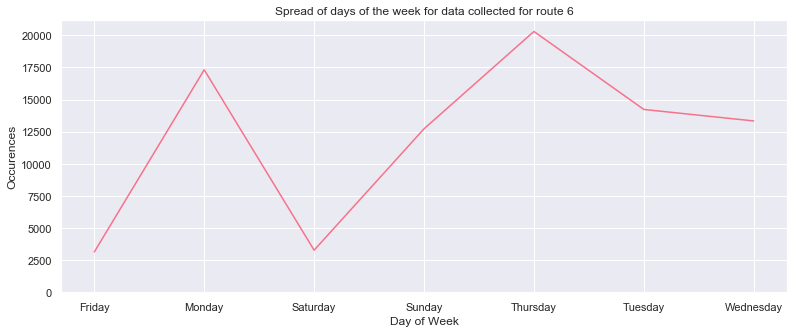

In [135]:
# Want x axis to have day of week in order from Monday - Sunday if possible, but not necessary
for route in routes:
    spread_of_day_of_week(data[route], route)

## Helper Functions

In [186]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [188]:
def get_times_between_two_stops(stop_a, stop_b, b_id):
    
    """
    journey_times 
        - is a list of all journey times for a bus from stop a to stop b
    time_of_day_grouped 
        - is a list of lists where each sublist represents a time period of the day
        - each sublist contains the journey times for a bus for that time period
    time_of_day_labels
        - is a list of all colour codes for every journey from stop a to stop b
        - e.g. [1,3,2] represents 3 journeys, where the 1st journey was in the time period 03-06
    """

    journey_times = []
    time_of_day_grouped = [[] for i in range (0, 8)]
    time_of_day_labels = []

    a = time.time()
    for i, journey in stop_a.iterrows():
        [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
        match_id = bus_id + '_' + b_id + '_' + date + '_' + direction + '_'
        start = convert_time_to_datetime(journey['expected_arrival'])
        for j, match in stop_b.iterrows():
            [bus_idx, stop_idx, datex, directionx, num_tripx] = match['vehicle_id'].split('_')
            end = convert_time_to_datetime(match['expected_arrival'])
            if match['vehicle_id'].startswith(match_id):
                # Error in some of the data where trip num doesn't match so need to check that the travel time
                # is within a reasonable time period
                
                if (end - start < dt.timedelta(minutes = 40)) & (end - start > dt.timedelta(minutes = 0)):
                    diff = end - start
                    journey_times.append(diff)
                    section_of_day = get_time_of_day_group(match['expected_arrival'])
                    time_of_day_labels.append(section_of_day)
                    flt = diff.total_seconds() / 60
                    time_of_day_grouped[section_of_day].append(flt)
                    break

    print("Time taken: ", (time.time() - a))
    for i, group in enumerate(time_of_day_grouped):
        if len(group) == 0:
            time_of_day_grouped[i].append(np.nan)
    
    return journey_times, time_of_day_grouped, time_of_day_labels

In [216]:
def calc_info_for_graphs(journey_times):
    """
    travel_times 
        - is a list of all journey times for a bus from stop a to stop b converted into minutes
    avg_time
        - is the average amount of time for a journey from stop a to stop b across all time periods (minutes)
    counts
        - is a list of the number of times each journey time occurs
        - e.g. a journey time of 16 minutes may occur 2 times.
    """

    travel_times = [(time.total_seconds() / 60) for time in journey_times]
    if len(travel_times) > 0:
        avg_time = sum(travel_times) / len(travel_times)
        counts = [journey_times.count(elem) for elem in journey_times]
        return travel_times, avg_time, counts

## Outlier Analysis

In [206]:
def graph_travel_times(travel_times, avg_time, counts, stop_a, stop_b, route):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.scatter(travel_times, counts)
    ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
    ax.set_xlabel("Travel Time (minute)")
    ax.set_ylabel("Occurences")
    ax.set_ylim(0)
    ax.set_title("Graph showing the travel time of bus {} from {} to {}".format(route, stop_a, stop_b))
    ax.legend()
    plt.show()
    
def graph_travel_times_with_outliers(travel_times, avg_time, counts, labels, stop_a, stop_b, route):
    # labels = outliers found by z_score
    
    cs = [colours[0], colours[3]]
    
    fig, ax = plt.subplots(figsize=(15,6))
    sctr = ax.scatter(travel_times, counts, c=labels, cmap=matplotlib.colors.ListedColormap(cs))
    ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
    ax.set_xlabel("Travel Time (minute)")
    ax.set_ylabel("Occurences")
    ax.set_ylim(0)
    ax.set_title("Graph showing the travel time of bus {} from {} to {}".format(route, stop_a, stop_b))
    ax.legend()
    
    cbar = fig.colorbar(sctr)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Data", "Outliers"])

In [207]:
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    outlier_labels = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
            outlier_labels.append(1)
        else:
            outlier_labels.append(0)
    
    return outlier_indexes, outlier_labels

###  Average time taken for a bus to travel from "North End Road" to "Phillimore Gardens" on route 9 (inbound)

In [210]:
north_end_rd_index = stops_in_sequence_inbound.get("9").index("North End Road")
print(north_end_rd_index)
print(stops_in_sequence_inbound.get("9").index("Phillimore Gardens"))

3
8


In [168]:
b_9 = data["9"]
north_end_rd = b_9.loc[(b_9['bus_stop_name'] == 'North End Road') & (b_9['direction'] == 'inbound')]
[_, north_end_rd_id, _, _, _] = north_end_rd.iloc[0]['vehicle_id'].split('_')
print(north_end_rd.shape)
print(north_end_rd_id)
north_end_rd.head()

(882, 5)
490010357F


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
6,North End Road,2020-04-02 11:42:14,15455_490010357F_2020-04-02_out_4,2020-04-02 11:12:42,inbound
143,North End Road,2020-03-19 10:39:04,15458_490010357F_2020-03-19_out_0,2020-03-19 10:23:21,inbound
147,North End Road,2020-03-31 07:33:30,14462_490010357F_2020-03-31_out_0,2020-03-31 07:33:39,inbound
231,North End Road,2020-04-01 10:46:17,14468_490010357F_2020-04-01_out_0,2020-04-01 10:45:08,inbound
239,North End Road,2020-04-02 10:17:16,14558_490010357F_2020-04-02_out_4,2020-04-02 09:50:43,inbound


In [169]:
phillimore_g = b_9.loc[(b_9['bus_stop_name'] == 'Phillimore Gardens') & (b_9['direction'] == 'inbound')]
[_, phillimore_g_id, _, _, _] = phillimore_g.iloc[0]['vehicle_id'].split('_')
print(phillimore_g.shape)
print(phillimore_g_id)
phillimore_g.head()

(902, 5)
490010984T


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
60,Phillimore Gardens,2020-04-06 05:05:29,15556_490010984T_2020-04-06_out_0,2020-04-06 05:05:39,inbound
106,Phillimore Gardens,2020-03-31 07:02:06,14516_490010984T_2020-03-31_out_0,2020-03-31 07:01:10,inbound
135,Phillimore Gardens,2020-03-31 06:54:22,15446_490010984T_2020-03-31_out_0,2020-03-31 06:54:10,inbound
152,Phillimore Gardens,2020-03-29 10:01:31,14510_490010984T_2020-03-29_out_0,2020-03-29 09:43:11,inbound
166,Phillimore Gardens,2020-03-27 09:13:45,14468_490010984T_2020-03-27_out_0,2020-03-27 09:11:42,inbound


In [193]:
journey_times_np9, time_of_day_grouped_np9, time_of_day_labels_np9 = get_times_between_two_stops(north_end_rd, phillimore_g, phillimore_g_id)
travel_times_np9, avg_time_np9, counts_np9 = calc_info_for_graphs(journey_times_np9)
print("Average travel time from North End Road to Phillimore Gardens is {} minutes".format(avg_time_np9))

Time taken:  91.32515621185303
Average travel time from North End Road to Phillimore Gardens is 4.854799196787141 minutes


The standard deviation (in minutes) is:  1.7591602769166337
The variance (in minutes) is:  3.0946448798814075


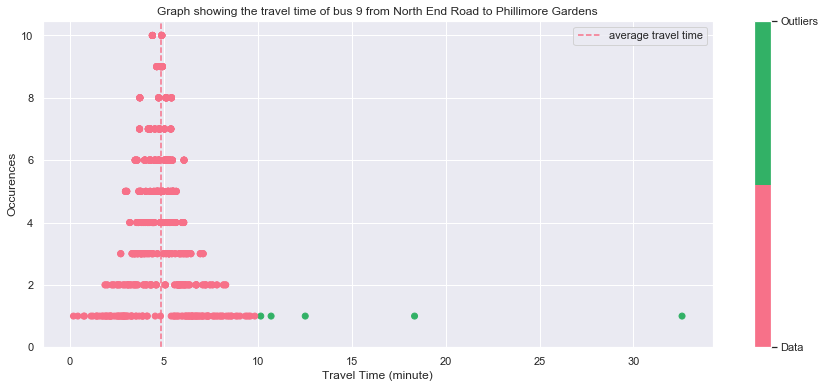

In [208]:
outlier_indexes_np9, outlier_labels_np9 = detect_outlier_z_score(travel_times_np9)
print("The standard deviation (in minutes) is: ", statistics.stdev(travel_times_np9))
print("The variance (in minutes) is: ", statistics.variance(travel_times_np9))
graph_travel_times_with_outliers(travel_times_np9, avg_time_np9, counts_np9, outlier_labels_np9, "North End Road", "Phillimore Gardens", "9")

### Variance and outliers for gaps of increasing size on route 9

In [211]:
variances = []
sds = []

for i in range(4, 20):
    stop_b_name = stops_in_sequence_inbound.get("9")[i]
    stop_b = b_9.loc[(b_9['bus_stop_name'] == stop_b_name) & (b_9['direction'] == 'inbound')]
    [_, b_id, _, _, _] = stop_b.iloc[0]['vehicle_id'].split('_')

    journey_times, _, _ = get_times_between_two_stops(north_end_rd, stop_b, b_id)
    travel_times, _, _ = calc_info_for_graphs(journey_times)
    variances.append(statistics.stdev(travel_times))
    sds.append(statistics.variance(travel_times))

Time taken:  65.07886910438538
Time taken:  59.943408250808716
Time taken:  50.37676191329956
Time taken:  58.47482919692993
Time taken:  55.75551629066467
Time taken:  97.01577591896057
Time taken:  90.3114321231842
Time taken:  65.7698302268982
Time taken:  129.29656982421875
Time taken:  85.20985913276672
Time taken:  74.13587617874146
Time taken:  66.89457678794861
Time taken:  69.5764410495758
Time taken:  88.78641891479492
Time taken:  93.18455624580383
Time taken:  118.95294427871704


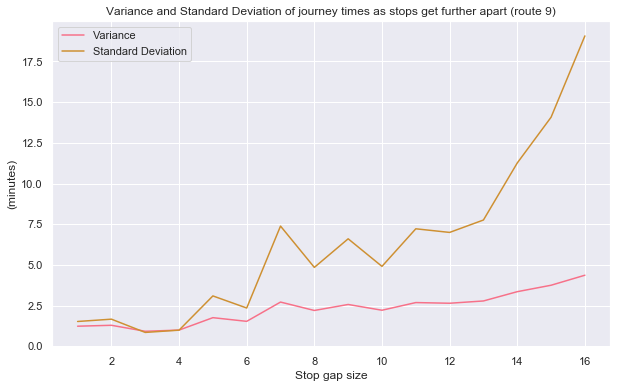

In [212]:
fig, ax = plt.subplots(figsize=(10,6))
gap_size = [i for i in range(1,17)]
ax.plot(gap_size, variances, label = "Variance")
ax.plot(gap_size, sds, label = "Standard Deviation")
ax.legend()
ax.set_xlabel("Stop gap size")
ax.set_ylabel("(minutes)")
ax.set_title("Variance and Standard Deviation of journey times as stops get further apart (route 9)")
plt.show()

### Average time taken for a bus to travel from "All Souls Avenue" to "Nottinghill Gate Station" (inbound) for bus 52

In [195]:
b_52 = data["52"]

print(stops_in_sequence_inbound.get("52").index("All Souls Avenue"))
print(stops_in_sequence_inbound.get("52").index("Notting Hill Gate Station"))

ntg_stn = b_52.loc[(b_52['bus_stop_name'] == 'Notting Hill Gate Station') & (b_52['direction'] == 'inbound')]
[_, ntg_stn_id, _, _, _] = ntg_stn.iloc[0]['vehicle_id'].split('_')
print(ntg_stn.shape)
print(ntg_stn_id)

all_souls_avn = b_52.loc[(b_52['bus_stop_name'] == 'All Souls Avenue') & (b_52['direction'] == 'inbound')]
[_, all_souls_avn_id, _, _, _] = all_souls_avn.iloc[0]['vehicle_id'].split('_')
print(all_souls_avn.shape)
print(all_souls_avn_id)

5
21
(1360, 5)
490000167G
(1302, 5)
490003256N


In [196]:
journey_times_na52, time_of_day_grouped_na52, time_of_day_labels_na52 = get_times_between_two_stops(all_souls_avn, ntg_stn, ntg_stn_id)
travel_times_na52, avg_time_na52, counts_na52 = calc_info_for_graphs(journey_times_na52)
print("Average travel time between from All Souls Avenue to Nottinghill Gate Station is {} minutes".format(avg_time_na52))

Time taken:  119.74494194984436
Average travel time between from All Souls Avenue to Nottinghill Gate Station is 14.968603382433171 minutes


The standard deviation (in minutes) is:  2.7611675438317818
The variance (in minutes) is:  7.6240462051100355


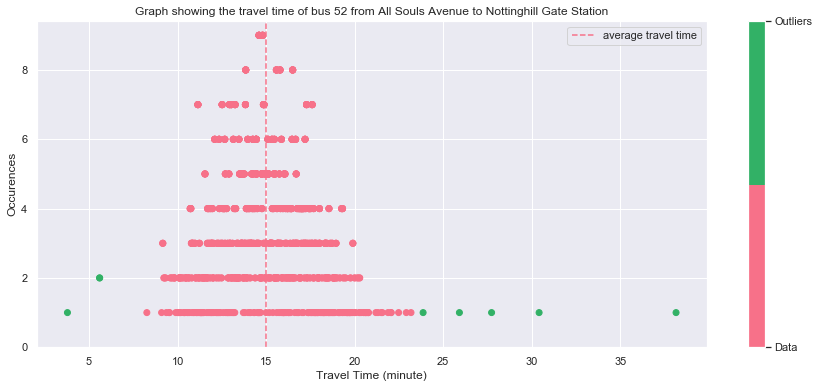

In [201]:
outlier_indexes_na52, outlier_labels_na52 = detect_outlier_z_score(travel_times_na52)
print("The standard deviation (in minutes) is: ", statistics.stdev(travel_times_na52))
print("The variance (in minutes) is: ", statistics.variance(travel_times_na52))
graph_travel_times_with_outliers(travel_times_na52, avg_time_na52, counts_na52, outlier_labels_na52, "All Souls Avenue", "Nottinghill Gate Station", "52")

### Variance and outliers for gaps of increasing size on route 52

In [ ]:
variances = []
sds = []

for i in range(4, 20):
    stop_b_name = stops_in_sequence_inbound.get("52")[i]
    stop_b = b_52.loc[(b_52['bus_stop_name'] == stop_b_name) & (b_52['direction'] == 'inbound')]
    [_, b_id, _, _, _] = stop_b.iloc[0]['vehicle_id'].split('_')

    journey_times, _, _ = get_times_between_two_stops(all_souls_avn, stop_b, b_id)
    if len(journey_times) > 0:
        travel_times, _, _ = calc_info_for_graphs(journey_times)
        variances.append(statistics.stdev(travel_times))
        sds.append(statistics.variance(travel_times))

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
gap_size = [i for i in range(1,17)]
ax.plot(gap_size, variances, label = "Variance")
ax.plot(gap_size, sds, label = "Standard Deviation")
ax.legend()
ax.set_xlabel("Stop gap size")
ax.set_ylabel("(minutes)")
ax.set_title("Variance and Standard Deviation of journey times as stops get further apart (route 9)")
plt.show()

### Average time taken for a bus to travel from "Florence Road" to "Star Lane" on route 69 (outbound)

In [203]:
print(stops_in_sequence_outbound.get("69").index("Florence Road"))
print(stops_in_sequence_outbound.get("69").index("Star Lane"))

b_69 = data["69"]
florence_rd = b_69.loc[(b_69['bus_stop_name'] == 'Florence Road') & (b_69['direction'] == 'outbound')]
[_, florence_rd_id, _, _, _] = florence_rd.iloc[0]['vehicle_id'].split('_')
print(florence_rd.shape)
print(florence_rd_id)

star_lane = b_69.loc[(b_69['bus_stop_name'] == 'Star Lane') & (b_69['direction'] == 'outbound')]
[_, star_lane_id, _, _, _] = star_lane.iloc[0]['vehicle_id'].split('_')
print(star_lane.shape)
print(star_lane_id)

29
34
(734, 5)
490006878N2
(734, 5)
490012596N


In [204]:
journey_times_fs69, time_of_day_grouped_fs69, time_of_day_labels_fs69 = get_times_between_two_stops(florence_rd, star_lane, star_lane_id)
travel_times_fs69, avg_time_fs69, counts_fs69 = calc_info_for_graphs(journey_times_fs69)
print("Average travel time between Florence Road and Star Lane is {} minutes".format(avg_time_fs69))

Time taken:  63.877156019210815
Average travel time between Florence Road and Star Lane is 3.945336174242425 minutes


The standard deviation (in minutes) is:  1.0641892522720355
The variance (in minutes) is:  1.132498764651314


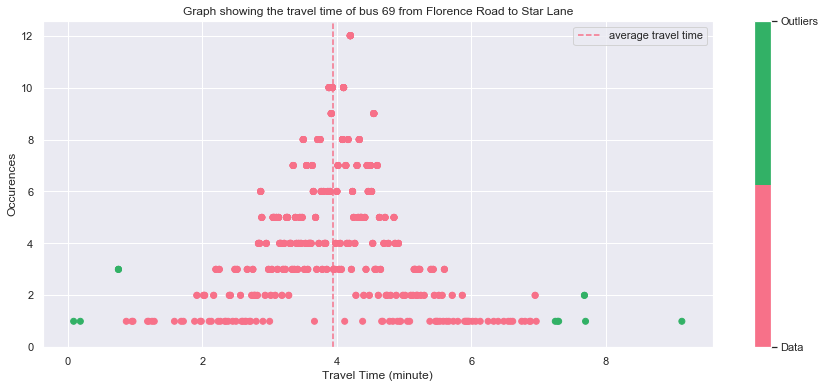

In [209]:
outlier_indexes_fs69, outlier_labels_fs69 = detect_outlier_z_score(travel_times_fs69)
print("The standard deviation (in minutes) is: ", statistics.stdev(travel_times_fs69))
print("The variance (in minutes) is: ", statistics.variance(travel_times_fs69))
graph_travel_times_with_outliers(travel_times_fs69, avg_time_fs69, counts_fs69, outlier_labels_fs69, "Florence Road", "Star Lane", "69")

## Effect of Time of Day on journey times

In [136]:
def get_time_of_day_group(given_time):
    hour = int(given_time[11:13])
    if (hour < 3) & (hour >= 0):
        return 0
    elif (hour < 6) & (hour >= 3):
        return 1
    elif (hour < 9) & (hour >= 6):
        return 2
    elif (hour < 12) & (hour >= 9):
        return 3
    elif (hour < 15) & (hour >= 12):
        return 4
    elif (hour < 18) & (hour >= 15):
        return 5
    elif (hour < 21) & (hour >= 18):
        return 6
    elif hour >= 21:
        return 7
    
colour_to_time_label = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-00"]
cs = [colours[i] for i in range(len(colours))]

In [184]:
def graph_travel_by_time_of_day(route, stop_a, stop_b, travel_times, counts, labels, avg_time):
    fig, ax = plt.subplots(figsize=(15,6))
    sctr = ax.scatter(travel_times, counts, c=labels, cmap=matplotlib.colors.ListedColormap(cs))
    ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
    ax.set_xlabel("Travel Time (minute)")
    ax.set_ylabel("Occurences")
    ax.set_ylim(0)
    ax.set_title("Graph showing the travel time of bus {} from {} to {} grouped by time of day of travel".format(route, stop_a, stop_b))
    ax.legend()

    cbar = fig.colorbar(sctr)
    cbar.set_ticks([0, 1, 2, 3, 4, 5, 6, 7])
    cbar.set_ticklabels(colour_to_time_label)
    cbar.ax.set_title("Time of day")

    plt.show()

def graph_travel_by_time_of_day_2(time_of_day_grouped, avg_time, route, stop_a, stop_b):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Travel Time (minutes)")

    for x, y in zip(colour_to_time_label, time_of_day_grouped):
        ax.scatter([x] * len(y), y)

    ax.plot(colour_to_time_label, [avg_time] * len(colour_to_time_label), 'k--', label='average time')
    ax.set_xticklabels(colour_to_time_label)
    ax.legend()
    ax.set_title("Graph showing the travel time of bus {} from {} to {} grouped by time of day of travel".format(route, stop_a, stop_b))
    plt.show()

###  Average time taken for a bus to travel from "North End Road" to "Phillimore Gardens" on route 9 (inbound)

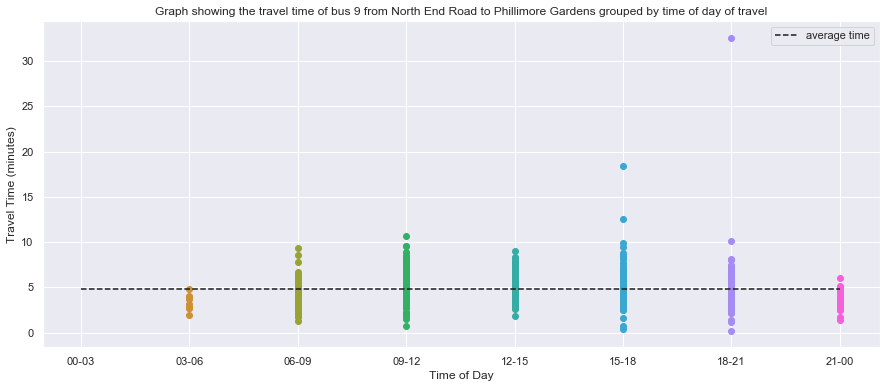

In [200]:
graph_travel_by_time_of_day_2(time_of_day_grouped_np9, avg_time_np9, "9", "North End Road", "Phillimore Gardens")

### Average time taken for a bus to travel from "All Souls Avenue" to "Nottinghill Gate Station" (inbound) for bus 52

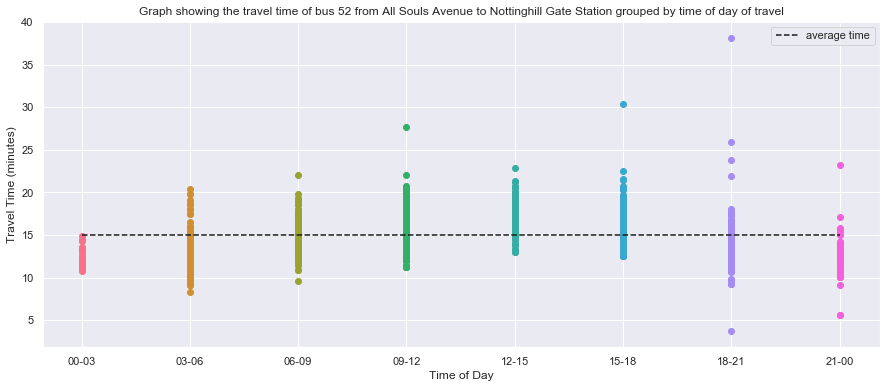

In [202]:
graph_travel_by_time_of_day_2(time_of_day_grouped_na52, avg_time_na52, "52", "All Souls Avenue", "Nottinghill Gate Station")

### Average time taken for a bus to travel from "Florence Road" to "Star Lane" on route 69 (outbound)

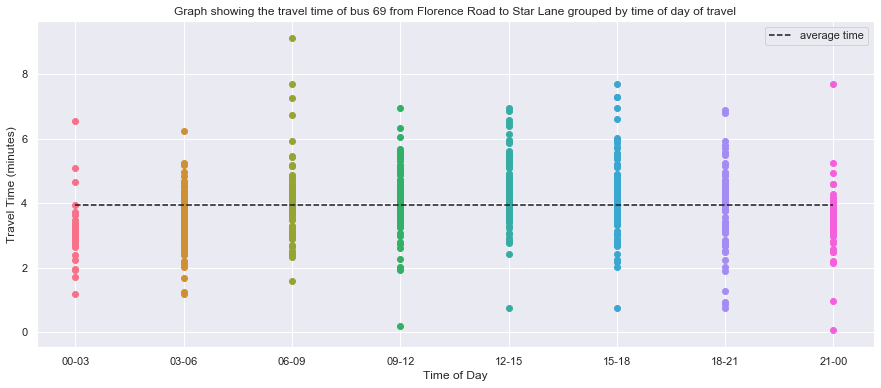

In [160]:
graph_travel_by_time_of_day_2(time_of_day_grouped_fs69, avg_time_fs69, "69", "Florence Road", "Star Lane")

## Aggregate all the travel times for 2 stops that are a set number of stops apart (say 10 stops apart) and plot as above to see a trend in the time of day -> then can use this to decide weightings for times of day

e.g. 09-12 tends to have higher journey times, so if trying to predict a journey time during this period, maybe have a wider range of times to consider i.e. moer likely to consider outliers than say 00-03?